In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import os


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


In [3]:
###TO DO@1: consider other parameters + precipitation
###CASE:1 - predict each parameters -> input to classification model
###CASE:2 - predict overall system in LSTM
###TO DO@2: create git hub repository
'''
data = pd.read_csv('/content/2021_06.csv', header=None,encoding="cp949")
data4 = pd.read_csv('/content/2022_06.csv', header=None,encoding="cp949")
data7 = pd.read_csv('/content/2023_06.csv', header=None,encoding="cp949")

data8 = pd.read_csv('/content/seoul_2023_07.csv', header=None,encoding="cp949")
data9 = pd.read_csv('/content/seoul_2023_08.csv', header=None,encoding="cp949")
data5 = pd.read_csv('/content/seoul_2022_07.csv', header=None,encoding="cp949")
data6 = pd.read_csv('/content/seoul_2022_08.csv', header=None,encoding="cp949")
data2 = pd.read_csv('/content/seoul_2021_07.csv', header=None,encoding="cp949")
data3 = pd.read_csv('/content/seoul_2021_08.csv', header=None,encoding="cp949")
data.head()
'''

,0,1,2
0,region,precipitation,time
1,강남구,0,2021-06-01 0:09
2,강남구,0,2021-06-01 0:09
3,강남구,0,2021-06-01 0:09
4,강남구,0,2021-06-01 0:19


In [4]:
'''
data=np.array(data)
data2=np.array(data2)
data3=np.array(data3)
data4=np.array(data4)
data5=np.array(data5)
data6=np.array(data6)
data7=np.array(data7)
data8=np.array(data8)
data9=np.array(data9)
data2 = data2[1:]
data3 = data3[1:]
data4 = data4[1:]
data5 = data5[1:]
data6 = data6[1:]
data7 = data7[1:]
data8 = data8[1:]
data9 = data9[1:]
data = np.concatenate((data,data2,data3,data4,data5,data6,data7,data8,data9))
data
data9
'''

array([['강남구', '2', '2023-08-04 14:49'],
       ['강남구', '0', '2023-08-04 14:49'],
       ['강남구', '0', '2023-08-04 14:49'],
       ...,
       ['중랑구', '0', '2023-08-30 20:19'],
       ['중랑구', '0', '2023-08-30 20:29'],
       ['중랑구', '0', '2023-08-30 20:29']], dtype=object)

In [5]:
#np.save('seoul2_data.npy', data)


In [6]:
###########데이터 전처리 ###########
data = np.load('/content/seoul_data.npy', allow_pickle=True)

# 데이터셋을 Pandas DataFrame으로 변환
df = pd.DataFrame(data[1:], columns=data[0])
# 지역 날짜와 강수량 데이터 추출
df['time'] = pd.to_datetime(df['time'])
df['precipitation'] = df['precipitation'].astype(float)
regions = df['region'].unique()
print(regions)

precipitation = df['precipitation'].values
dates = df['time'].values

#print(dates)


['강남구' '강동구' '강북구' '강서구' '관악구' '광진구' '구로구' '금천구' '노원구' '도봉구' '동대문구' '동작구'
 '마포구' '서대문구' '서초구' '성동구' '성북구' '송파구' '양천구' '영등포구' '용산구' '은평구' '종로구' '중구'
 '중랑구']


In [7]:
region_data = {}

for region in regions:
    region_df = df[df['region'] == region][['time', 'precipitation']]
    region_df['time'] = pd.to_datetime(region_df['time'])
    region_df = region_df.sort_values('time')

    #scaler = MinMaxScaler()
    #region_df['precipitation'] = scaler.fit_transform(region_df[['precipitation']])

    region_data[region] = (region_df)


In [8]:
for i in regions:
  region_data[i]=region_data[i].dropna()

In [9]:
# 시계열 윈도우 생성 함수
def create_sequences(data, seq_length):
    sequences = []

    data2=[]
    for i in data:
      data2.append(i)


    for i in range(len(data2) - seq_length-4):
        sequence = data2[i:i + seq_length]

        label = data2[i + seq_length+4]
        sequences.append((sequence, label))
    return sequences

# 시계열 윈도우 생성 및 데이터 결합
seq_length = 12
all_sequences = []
#print(region_data.items())
i=0
for region, (region_df, _) in region_data.items():
   ps=region_data[region].precipitation


  #sequences = create_sequences(region_df['precipitation'].values, seq_length)
   sequences = create_sequences(ps, seq_length)
  # print(sequences)
   for seq, label in sequences:
       all_sequences.append((region, seq, label))


# 데이터를 입력(X), 출력(y), 지역 정보(region)으로 분리
regions, X, y = zip(*all_sequences)
X = np.array(X)
y = np.array(y)



In [10]:
# LSTM 입력 형식에 맞게 데이터 차원 변경
X = X.reshape((X.shape[0], X.shape[1], 1))

# 지역 정보를 수치형으로 변환 (Label Encoding)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
region_encoded = label_encoder.fit_transform(regions)
region_encoded = np.array(region_encoded).reshape(-1, 1)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Embedding, Flatten
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam


from keras.losses import mean_squared_error

def rmse(y_true, y_pred):
    return tf.sqrt(mean_squared_error(y_true, y_pred))

# 모델을 로드하기 전에 'rmse' 손실 함수를 등록합니다.
tf.keras.utils.get_custom_objects()['rmse'] = rmse

# 입력 레이어 정의
input_seq = Input(shape=(seq_length, 1))
input_region = Input(shape=(1,))

# 지역 정보를 Embedding하여 사용
embedding = Embedding(input_dim=len(regions), output_dim=10)(input_region)
embedding = Flatten()(embedding)

# 시계열 데이터를 LSTM으로 처리

lstm_out1 = LSTM(50, activation='relu', return_sequences=True)(input_seq)
lstm_out2 = LSTM(50, activation='relu', return_sequences=True)(input_seq)
lstm_out3 = LSTM(50, activation='relu')(lstm_out2)

# LSTM 출력과 지역 임베딩을 연결
combined = Concatenate()([lstm_out3, embedding])
# concanate output and region

# define output layer
output = Dense(1)(combined)
#optimizer = Adam(learning_rate=0.001)


model = Model(inputs=[input_seq, input_region], outputs=output)
model.compile(optimizer='adam', loss='rmse',metrics=['accuracy'])


history=model.fit([X, region_encoded], y, epochs=15, batch_size=64, validation_split=0.2)

Epoch 1/15
2437/2437 [==============================] - 102s 40ms/step - loss: 0.5669 - accuracy: 0.5566 - val_loss: 0.5173 - val_accuracy: 0.5670
Epoch 2/15
2437/2437 [==============================] - 96s 39ms/step - loss: 0.5590 - accuracy: 0.5557 - val_loss: 0.5119 - val_accuracy: 0.5655
Epoch 3/15
2437/2437 [==============================] - 95s 39ms/step - loss: 0.5573 - accuracy: 0.5551 - val_loss: 0.5120 - val_accuracy: 0.5661
Epoch 4/15
2437/2437 [==============================] - 97s 40ms/step - loss: 0.5563 - accuracy: 0.5550 - val_loss: 0.5107 - val_accuracy: 0.5670
Epoch 5/15
2437/2437 [==============================] - 97s 40ms/step - loss: 0.5551 - accuracy: 0.5544 - val_loss: 0.5112 - val_accuracy: 0.5631
Epoch 6/15
2437/2437 [==============================] - 94s 39ms/step - loss: 0.5543 - accuracy: 0.5544 - val_loss: 0.5100 - val_accuracy: 0.5619
Epoch 7/15
2437/2437 [==============================] - 94s 39ms/step - loss: 0.5537 - accuracy: 0.5546 - val_loss: 0.5098 

In [12]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim(0,10)  # x축 범위 설정
    plt.ylim(0, 10)
    plt.legend()
    plt.show()

def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.xlim(0, 10)  # x축 범위 설정
    plt.legend()
    plt.show()



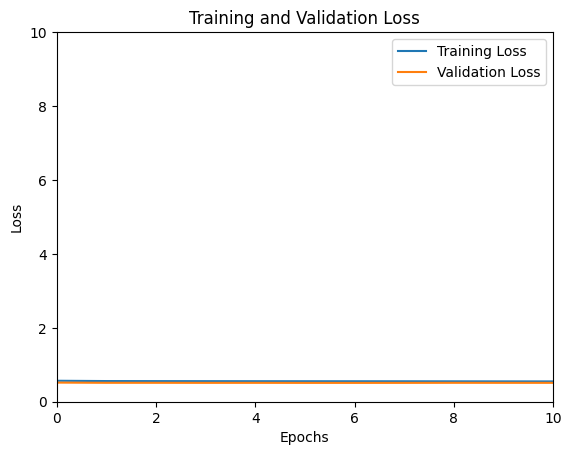

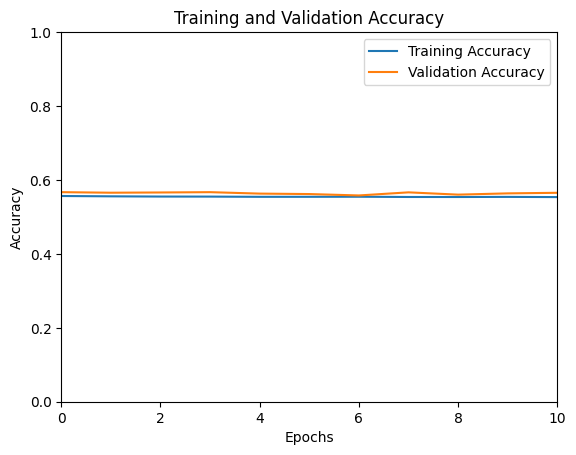

In [13]:
plot_loss(history)
plot_accuracy(history)


In [14]:
print(X.shape)

(194909, 12, 1)


In [15]:
model.save('temp_1day_prediction.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# 새로운 데이터 시퀀스
region_encoded = label_encoder.transform(['강남구'])
region_encoded = np.array(region_encoded).reshape(-1, 1)
new_seq = [0,0,1,1,1,1,1,2.5, 5, 5.5,4.5,3.5]  # 예시 데이터
new_seq2 = [0,1,1,1,1,1,2.5, 5, 5.5,4.5,3.5,1.5]  # 예시 데이터
new_seq3 = [1,1,1,1,1,2.5, 5, 5.5,4.5,3.5,1.5,1]  # 예시 데이터
new_seq4 = [1,1,1,1,2.5, 5, 5.5,4.5,3.5,1.5,1,1]
new_seq5 = [1,1,1,2.5, 5, 5.5,4.5,3.5,1.5,1,1,0.5]

new_seq6 = [1,1,2.5, 5, 5.5,4.5,3.5,1.5,1,1,0.5,1]
new_seq = np.array(new_seq,).reshape(1, seq_length)
new_seq2 = np.array(new_seq2,).reshape(1, seq_length)
new_seq3 = np.array(new_seq3,).reshape(1, seq_length)
new_seq4 = np.array(new_seq4,).reshape(1, seq_length)
new_seq5 = np.array(new_seq5,).reshape(1, seq_length)
new_seq6 = np.array(new_seq6,).reshape(1, seq_length)
total = 0

predict_result=model.predict([new_seq,region_encoded])
predict_result2=model.predict([new_seq2,region_encoded])
predict_result3=model.predict([new_seq3,region_encoded])
predict_result4=model.predict([new_seq4,region_encoded])
predict_result5=model.predict([new_seq5,region_encoded])
predict_result6=model.predict([new_seq6,region_encoded])
total = predict_result[0][0] + predict_result2[0][0] + predict_result3[0][0]+ predict_result4[0][0]+ predict_result5[0][0]+ predict_result6[0][0]
print("60분 강수량 예측: ")
print(total)
print(predict_result[0][0])
print(predict_result2[0][0])
print(predict_result3[0][0])
print(predict_result6[0][0])
print(predict_result5[0][0])
print(predict_result4[0][0])




1/1 [==============================] - 0s 26ms/step
60분 강수량 예측: 
5.377062
1.2913984
0.8983091
0.8925613
0.802192
0.59318
0.8994211


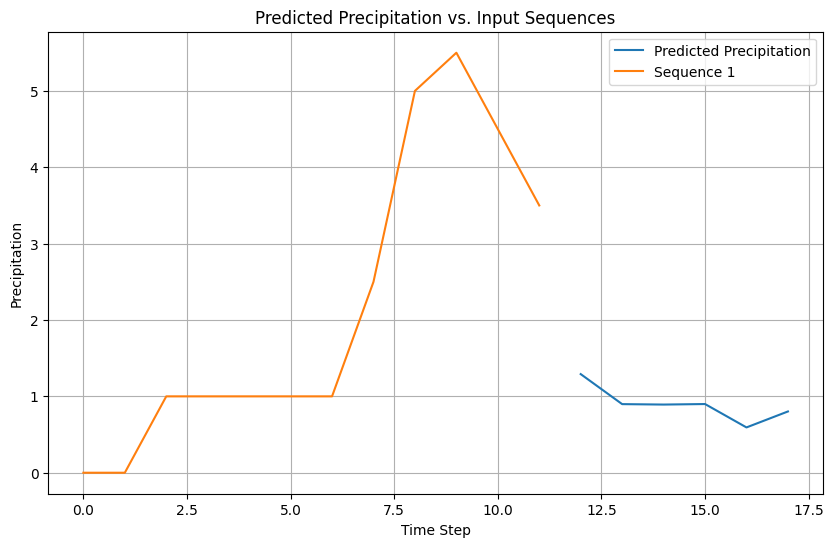

In [17]:
from math import nan
import matplotlib.pyplot as plt

# 예측 결과 저장
predictions = [nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,predict_result[0][0],predict_result2[0][0], predict_result3[0][0],predict_result4[0][0],predict_result5[0][0],predict_result6[0][0]]

# 예측에 사용된 데이터
sequences = [new_seq.flatten()]

# 그래프로 시각화
plt.figure(figsize=(10, 6))

# 예측 결과 그래프
plt.plot(predictions, label='Predicted Precipitation')

# 예측에 사용된 데이터 그래프
for i, seq in enumerate(sequences):
    plt.plot(seq, label=f'Sequence {i+1}')

plt.xlabel('Time Step')
plt.ylabel('Precipitation')
plt.title('Predicted Precipitation vs. Input Sequences')
plt.legend()
plt.grid(True)
plt.show()
